In [11]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.neighbors import NearestNeighbors
from ast import literal_eval
import matplotlib.pyplot as plt
import joblib

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [14]:
!ls

2025-08-08_2143_submission.csv	kaggle.json		 test_features.csv
2025-08-11_1658_submission.csv	model_8043		 tracks.csv
artists.csv			model_rf_rs_80		 train_features.csv
breast_cancer_model_rf_9649	new_submission.csv	 train_labels.csv
dict_artists.json		rf_water_submission.csv
dt_new_submission.csv		sample_submission.csv


In [15]:
tracks = pd.read_csv('tracks.csv')
artists = pd.read_csv('artists.csv')

Tracks dataset includes:
* id
* name
* popularity
* duration_ms
* explicit
* artists
* id_artists
* release_date
* danceability
* energy
* key
* loudness
* mode
* speechiness
* acousticness
* instrumentalness
* liveness
* valence
* tempo
* time_signature

In [16]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


Artists dataset includes:
* id
* followers
* genres
* name
* popularity

In [17]:
artists.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


# Cleanup

In [18]:
# make sure that there are no duplicates
tracks = tracks.drop_duplicates()
artists = artists.drop_duplicates()

In [19]:
# turn strings of lists into actual lists
tracks['artists'] = tracks['artists'].apply(literal_eval)
tracks['id_artists'] = tracks['id_artists'].apply(literal_eval)

In [21]:
# make a year column
tracks['year'] = pd.to_datetime(tracks['release_date'], format='mixed').dt.year

In [22]:
# tracks have multiple artists listed, we'll use the first artist mentioned
tracks['first_artist_id'] = tracks['id_artists'].apply(lambda x: x[0])

In [23]:
tracks.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,45tIt06XoI0Iio4LBEVpls
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,14jtPCOoNZwquk5wd9DxrY
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,5LiOoJbxVSAMkBS2fUm3X2
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,5LiOoJbxVSAMkBS2fUm3X2
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,3BiJGZsyX9sJchTqcSA7Su


In [24]:
# turn genre stringified lists into actual lists
artists['genres'] = artists['genres'].apply(literal_eval)

In [25]:
artists.columns = ['artist_id', 'artist_followers', 'artist_genres', 'artist_name', 'artist_popularity']
artists.head()

,artist_id,artist_followers,artist_genres,artist_name,artist_popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [26]:
# inner merge the two dataframes on artist_id
df = pd.merge(artists, tracks, how='inner', left_on='artist_id', right_on='first_artist_id')

print(df.shape)
df.head()

(574812, 27)


,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,1YZkudiD6LfY5vmZKdOTyO,Roodade Ghame Ulfat Unse - Dialogues,5,46893,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,7DLDYPMRJ0NFPcBTlg04DE
1,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,36OG5Ep6IPA4Mj6TxoTpcw,Jab Ham Chale To Saya Bhi Apna - Dialogues,6,31013,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,7DLDYPMRJ0NFPcBTlg04DE
2,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,0JqKK01MXbnDhBKKdcUCnX,Teach Me Tonight,15,170667,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,1OCPhFtvkZDLUJJkrJfD2G
3,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2iKCL9YGGTpDPen0LhzcX2,Boom Boom Boomerang,8,136120,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,1OCPhFtvkZDLUJJkrJfD2G
4,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2fwms7R3b5N8aBnJ1CaltH,Snowbound for Christmas,1,180427,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,1OCPhFtvkZDLUJJkrJfD2G


In [34]:
# drop tracks that have null values (just one)
# df[df['artist_followers'].isnull() == True]

df = df.dropna()

print(df.shape)
df.head()

(574811, 27)


,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,1YZkudiD6LfY5vmZKdOTyO,Roodade Ghame Ulfat Unse - Dialogues,5,46893,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,7DLDYPMRJ0NFPcBTlg04DE
1,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,36OG5Ep6IPA4Mj6TxoTpcw,Jab Ham Chale To Saya Bhi Apna - Dialogues,6,31013,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,7DLDYPMRJ0NFPcBTlg04DE
2,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,0JqKK01MXbnDhBKKdcUCnX,Teach Me Tonight,15,170667,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,1OCPhFtvkZDLUJJkrJfD2G
3,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2iKCL9YGGTpDPen0LhzcX2,Boom Boom Boomerang,8,136120,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,1OCPhFtvkZDLUJJkrJfD2G
4,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2fwms7R3b5N8aBnJ1CaltH,Snowbound for Christmas,1,180427,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,1OCPhFtvkZDLUJJkrJfD2G


# Exploratory Data Analysis

some graphs

<Axes: >

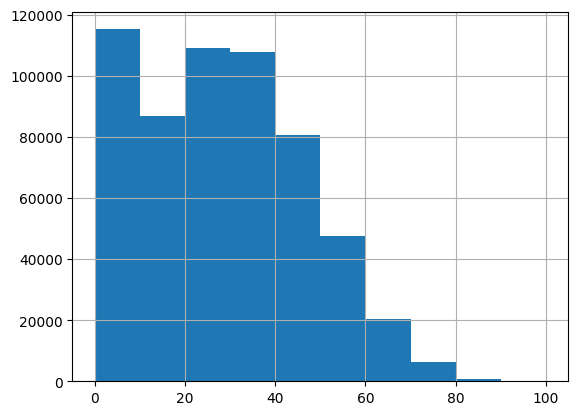

In [35]:
df['popularity'].hist()

<Axes: >

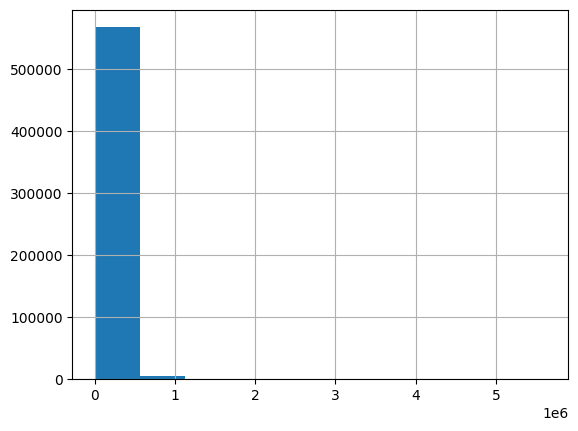

In [36]:
# definitely some outliers in terms of duration
df['duration_ms'].hist()

In [37]:
# the longest track is ~ 93 minutes long...
df['duration_ms'].max() / 1000 / 60

93.68696666666666

In [38]:
# summary statistics of duration (in seconds)
(df['duration_ms'] / 1000).describe()

,duration_ms
count,574811.000000
mean,229.849679
std,122.116153
min,3.344000
25%,175.373000
50%,215.000000
75%,263.867000
max,5621.218000


In [40]:
# 4.4% of songs are explicit
df['explicit'].value_counts(normalize=True)*100

,proportion
explicit,
0,95.608122
1,4.391878


<Axes: >

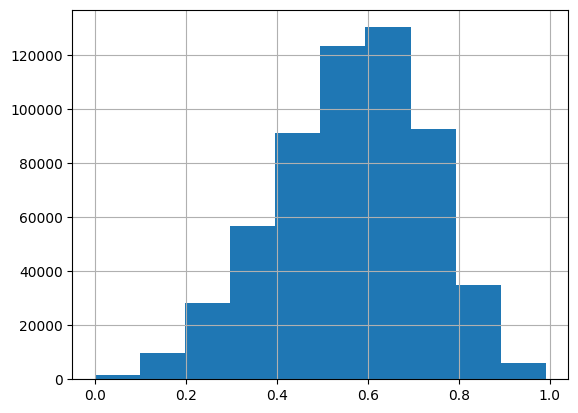

In [41]:
# normalized between 0 and 1
df['danceability'].hist()

<Axes: >

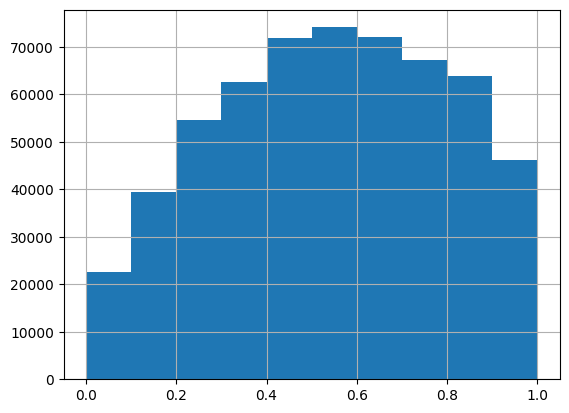

In [42]:
# normalized between 0 and 1
df['energy'].hist()

<Axes: >

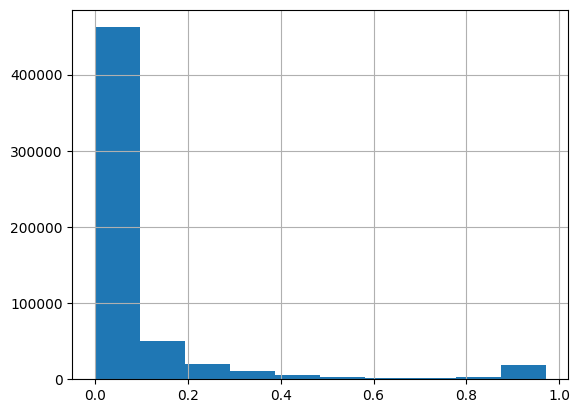

In [43]:
# normalized between 0 and 1
# I wonder if the very speechy ones are podcasts or something?
df['speechiness'].hist()

<Axes: >

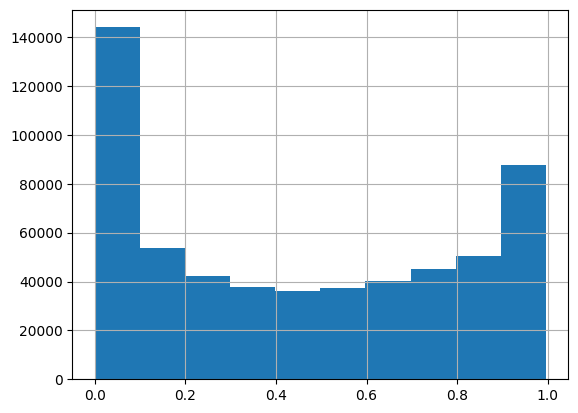

In [44]:
# normalized between 0 and 1
df['acousticness'].hist()

<Axes: >

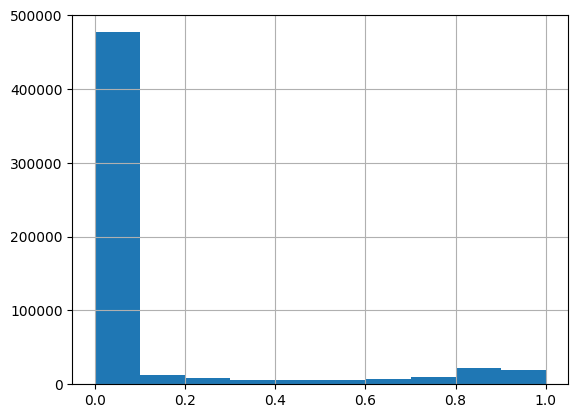

In [45]:
# normalized between 0 and 1
df['instrumentalness'].hist()

<Axes: >

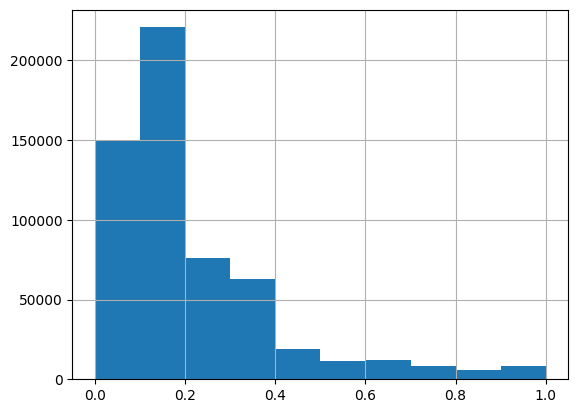

In [46]:
# normalized between 0 and 1
df['liveness'].hist()

<Axes: >

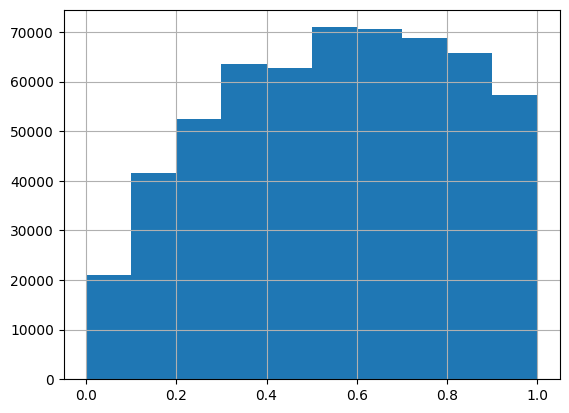

In [47]:
# normalized between 0 and 1
df['valence'].hist()

<Axes: >

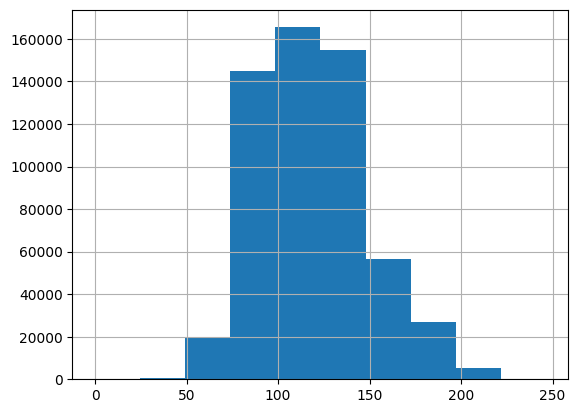

In [48]:
# Measured in BPM (beats per minute)
df['tempo'].hist()

In [49]:
# percentage of time signatures
df['time_signature'].value_counts(normalize=True)*100

,proportion
time_signature,
4,85.856742
3,11.031278
5,1.940638
1,1.124370
0,0.046972


In [50]:
# Major vs Minor key?
df['mode'].value_counts(normalize=True)*100

,proportion
mode,
1,65.92132
0,34.07868


In [51]:
df['key'].value_counts(normalize=True).sort_index()*100

,proportion
key,
0,12.759324
1,7.096767
2,11.362865
3,3.677209
4,8.235229
5,9.150834
6,5.260686
7,12.580483
8,5.696481


# Training a NearestNeighbors on only track-level numeric features and artist genre

In [52]:
df.head()

,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id
0,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,1YZkudiD6LfY5vmZKdOTyO,Roodade Ghame Ulfat Unse - Dialogues,5,46893,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,7DLDYPMRJ0NFPcBTlg04DE
1,7DLDYPMRJ0NFPcBTlg04DE,187.0,[],Guru Dutt,2,36OG5Ep6IPA4Mj6TxoTpcw,Jab Ham Chale To Saya Bhi Apna - Dialogues,6,31013,0,[Guru Dutt],[7DLDYPMRJ0NFPcBTlg04DE],1957-12-30,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,7DLDYPMRJ0NFPcBTlg04DE
2,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,0JqKK01MXbnDhBKKdcUCnX,Teach Me Tonight,15,170667,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,1OCPhFtvkZDLUJJkrJfD2G
3,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2iKCL9YGGTpDPen0LhzcX2,Boom Boom Boomerang,8,136120,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,1OCPhFtvkZDLUJJkrJfD2G
4,1OCPhFtvkZDLUJJkrJfD2G,155.0,[],The De Castro Sisters,8,2fwms7R3b5N8aBnJ1CaltH,Snowbound for Christmas,1,180427,0,[The De Castro Sisters],[1OCPhFtvkZDLUJJkrJfD2G],1955-06-01,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,1OCPhFtvkZDLUJJkrJfD2G


# TFIDF of Genres

We will combine all genres into a single document and then use TF-IDF vectorization to create a numeric representation of the words used to describe the genre.

In [ ]:
# combine genre strings into one big string (document) per track
df['genre_doc'] = df['artist_genres'].apply(lambda x: " ".join(x))

In [55]:
df[df['genre_doc'] != ''].head()

,artist_id,artist_followers,artist_genres,artist_name,artist_popularity,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,first_artist_id,genre_doc
12,7frYUe4C7A42uZqCzD34Y4,53636.0,"[desi pop, punjabi hip hop, punjabi pop]",Sultaan,53,3qWI4prgSotUOGR4BfOreW,Clutch Baliye,50,152687,0,"[Sultaan, Gagan]","[7frYUe4C7A42uZqCzD34Y4, 3kfNgIiPN2rdxVEQg6L3lW]",2019-12-10,0.693,0.569,0,-9.153,1,0.2790,0.0049,0.000000,0.0789,0.429,179.757,4,2019,7frYUe4C7A42uZqCzD34Y4,desi pop punjabi hip hop punjabi pop
13,72578usTM6Cj5qWsi471Nc,248568.0,"[filmi, indian folk, indian rock, kannada pop]",Raghu Dixit,52,39KS96tkCoJMz9P5m1ZqHT,Ninna Poojege Bande Mahadeshwara,36,253753,0,"[Raghu Dixit, Haricharan]","[72578usTM6Cj5qWsi471Nc, 1QvyquqkuuwUzdszyoKIy4]",2008,0.736,0.721,6,-11.590,0,0.1670,0.3360,0.000001,0.1690,0.728,99.896,4,2008,72578usTM6Cj5qWsi471Nc,filmi indian folk indian rock kannada pop
14,72578usTM6Cj5qWsi471Nc,248568.0,"[filmi, indian folk, indian rock, kannada pop]",Raghu Dixit,52,0WzODQag2H6Ob1JPOpSYSM,Eno Ide,29,342230,0,[Raghu Dixit],[72578usTM6Cj5qWsi471Nc],2008,0.639,0.373,1,-11.386,1,0.0334,0.8470,0.022500,0.0938,0.404,125.960,4,2008,72578usTM6Cj5qWsi471Nc,filmi indian folk indian rock kannada pop
15,72578usTM6Cj5qWsi471Nc,248568.0,"[filmi, indian folk, indian rock, kannada pop]",Raghu Dixit,52,4uqs4He9JdU4ztAQtsgmyF,Ee Tanuvu Ninnade,28,310753,0,[Raghu Dixit],[72578usTM6Cj5qWsi471Nc],2008,0.508,0.537,2,-10.192,1,0.0403,0.3270,0.000005,0.1070,0.274,75.002,4,2008,72578usTM6Cj5qWsi471Nc,filmi indian folk indian rock kannada pop
16,72578usTM6Cj5qWsi471Nc,248568.0,"[filmi, indian folk, indian rock, kannada pop]",Raghu Dixit,52,555NYWQ1PbmLJiTW6XFwtr,Munjaane Manjalli,42,340245,0,[Raghu Dixit],[72578usTM6Cj5qWsi471Nc],2010-01-05,0.390,0.505,9,-8.671,1,0.0381,0.4210,0.000000,0.0918,0.280,113.706,4,2010,72578usTM6Cj5qWsi471Nc,filmi indian folk indian rock kannada pop


# Create Document-Term Matrix of Genre Token

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Only using the 100 most common tokens so that our dataframe doesn't
# excedd the amount of ram provided by Google Colab
# can increase the max_features parameter if working locally
vect = TfidfVectorizer(stop_words='english', lowercase=True, max_features=100)

dtm = vect.fit_transform(df['genre_doc'])

dtm = pd.DataFrame(data=dtm.todense(), columns=vect.get_feature_names_out())

print(dtm.shape)
dtm.head()

(574811, 100)


,adult,album,alternative,argentine,art,band,blues,bollywood,brazilian,brill,british,building,canadian,cantopop,classic,classical,contemporary,cool,country,cumbia,czech,dance,danish,desi,disco,dutch,early,easy,en,era,espanol,filmi,finnish,folk,french,funk,german,gold,greek,hard,hip,hoerspiel,hop,house,icelandic,indie,indonesian,israeli,italian,japanese,jazz,latin,listening,lounge,mandopop,mellow,metal,mexican,modern,mpb,musica,new,norwegian,nova,permanent,polish,pop,post,progressive,psychedelic,punk,ranchera,rap,reggae,regional,rock,roll,romantic,roots,russian,salsa,sertanejo,singer,soft,songwriter,soul,spanish,standards,sufi,swedish,swing,thai,trance,trap,tropical,turkish,uk,vintage,vocal,wave
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Create X Matrix of numeric song attributes combined with Document-Term Matrix

In [57]:
numeric_columns = ['popularity', 'duration_ms', 'explicit', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'year']

X = pd.concat([df[numeric_columns].reset_index(drop=True), dtm.reset_index(drop=True)], axis=1)

print(X.shape)
X.head()

(574811, 116)


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,adult,album,alternative,argentine,art,band,blues,bollywood,brazilian,brill,british,building,canadian,cantopop,classic,classical,contemporary,cool,country,cumbia,czech,dance,danish,desi,disco,dutch,early,easy,en,era,espanol,filmi,finnish,folk,french,funk,german,gold,greek,hard,hip,hoerspiel,hop,house,icelandic,indie,indonesian,israeli,italian,japanese,jazz,latin,listening,lounge,mandopop,mellow,metal,mexican,modern,mpb,musica,new,norwegian,nova,permanent,polish,pop,post,progressive,psychedelic,punk,ranchera,rap,reggae,regional,rock,roll,romantic,roots,russian,salsa,sertanejo,singer,soft,songwriter,soul,spanish,standards,sufi,swedish,swing,thai,trance,trap,tropical,turkish,uk,vintage,vocal,wave
0,5,46893,0,0.700,0.219,8,-11.896,1,0.4230,0.992,0.000000,0.178,0.539,106.112,1,1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,31013,0,0.439,0.311,1,-14.167,1,0.3270,0.960,0.243000,0.211,0.392,77.238,4,1957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,170667,0,0.357,0.185,7,-13.705,1,0.0309,0.802,0.000000,0.105,0.303,109.524,4,1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8,136120,0,0.576,0.299,3,-10.515,1,0.0661,0.878,0.000009,0.409,0.983,201.395,3,1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,180427,0,0.252,0.234,0,-10.615,1,0.0303,0.875,0.000000,0.371,0.295,95.664,4,1955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Use Nearest Neighbors to get 5 similar songs.

The dataset is still missing a lot of important features such as the spoken language of any lyrics as well as the lyrics themselves. The model is blind to this context.

The model will only be able to match songs based on the general characteristics of the music and the genre of the song. When evaluating the model, judgement should be done on the overall vibe, pace, intensity, etc. of the recommendations. More feature engineering is needed to make really great recommendations.

In [58]:
neigh = NearestNeighbors(n_neighbors=5, n_jobs=-1)
neigh.fit(X)

NearestNeighbors(n_jobs=-1)

In [59]:
track_name = "Hello, Dolly!"

# get index of first song that matches the song title exactly
track_index = df[df['name'] == track_name].index[0]

# look at potential selected track
df[df['name'] == track_name].iloc[0]

,227368
artist_id,3DKPVHC4GzISLpUdAapGiZ
artist_followers,6629.0
artist_genres,[]
artist_name,Carol Channing
artist_popularity,24
id,7vvnz6fQL16iWA0X8WDWy8
name,"Hello, Dolly!"
popularity,19
duration_ms,342533
explicit,0


In [61]:
# selects a single track, converts the series to a numpy array, losing column names, reshapes the array to 2D
# extracts the indices of the 6 nearest tracks (6 nearest neighbors)
# also returns distances to neighbors
distances, song_indices = neigh.kneighbors(X.iloc[track_index].values.reshape(1,-1), 6)

song_indices[0]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


array([227368, 405153, 321514, 408092, 421700,  37214])

In [62]:
def open_in_browser(song_indices):
  for index in song_indices:
    song = df.iloc[index]
    name = song['name']
    artist = song['artist_name']
    id = song['id']
    print(f'{name} by {artist} - https://open.spotify.com/track/{id}')

open_in_browser(song_indices[0])

Hello, Dolly! by Carol Channing - https://open.spotify.com/track/7vvnz6fQL16iWA0X8WDWy8
I Don't Even Know Myself - Live by The Who - https://open.spotify.com/track/48qS2iZ7DsLqR26RddDxUe
There'll Never Be Another You by Sonny Rollins - https://open.spotify.com/track/4FVkDTHzohvkruGSKg4qh6
Gori Ke Haath Mein by Mohammed Rafi - https://open.spotify.com/track/6WxBaUvymTAkze4tQ8aJli
The Greatest Love of All - Live by George Benson - https://open.spotify.com/track/4MPm1bsUsZCyJpmAbwPa6H
Bohu Rati Hol Jana by Jitul Sonowal - https://open.spotify.com/track/4tXtmYTobs6TTtuNlWA7Ow


# Export the Vectorizer and NearestNeighbors models

In [63]:
# export the TF-IDF Vectorizer to a file
joblib.dump(vect, 'vect.pkl')

['vect.pkl']

In [64]:
# export our NearestNeighbors to a file
# use compression or else the fill will take 30 mins or more to download
joblib.dump(neigh, 'neigh.pkl', compress=3)

['neigh.pkl']